# Load Images  
Quelle: [tensorflow.org](https://www.tensorflow.org/tutorials/load_data/images?hl=en)

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib

In [2]:
print(tf.__version__)

2.5.0-dev20210218


In [3]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname="flower_photos", untar=True)
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob("*/*.jpg")))
print(image_count)

3670


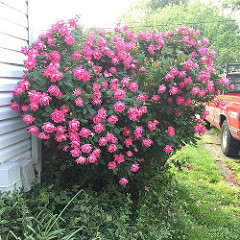

In [5]:
roses = list(data_dir.glob("roses/*"))
PIL.Image.open(str(roses[2]))

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, validation_split=0.2, subset="training", seed=123, image_size=(img_height, img_width), batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, validation_split=0.2, subset="validation", seed=123, image_size=(img_height, img_width), batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [10]:
import matplotlib.pyplot as plt

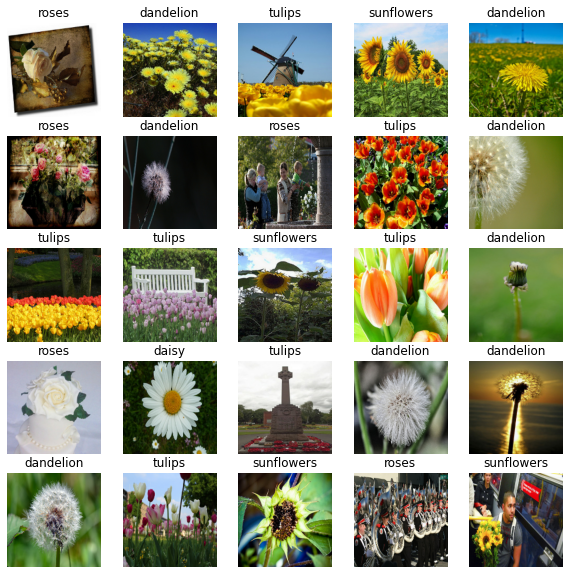

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [14]:
from tensorflow.keras import layers

In [16]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 0.99638706


In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
num_classes = 5

model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes)
])

In [22]:
model.compile(optimizer="adam", loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

In [23]:
model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3
92/92 [==============================] - 65s 361ms/step - loss: 1.3858 - accuracy: 0.3766 - val_loss: 1.1775 - val_accuracy: 0.5395
Epoch 2/3
92/92 [==============================] - 1s 16ms/step - loss: 1.0041 - accuracy: 0.6018 - val_loss: 1.0204 - val_accuracy: 0.6076
Epoch 3/3
92/92 [==============================] - 1s 16ms/step - loss: 0.8548 - accuracy: 0.6671 - val_loss: 0.9139 - val_accuracy: 0.6526


In [24]:
list_ds = tf.data.Dataset.list_files(str(data_dir/"*/*"), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [31]:
for f in list_ds.take(5):
    print(f.numpy())

b'/home/julius/.keras/datasets/flower_photos/roses/3634244527_e72c47842c_n.jpg'
b'/home/julius/.keras/datasets/flower_photos/dandelion/146023167_f905574d97_m.jpg'
b'/home/julius/.keras/datasets/flower_photos/roses/15566697073_9a214b700e_n.jpg'
b'/home/julius/.keras/datasets/flower_photos/roses/16772483324_09f24813a1_n.jpg'
b'/home/julius/.keras/datasets/flower_photos/sunflowers/2706736074_b0fba20b3e.jpg'


In [32]:
class_names = np.array(sorted([item.name for item in data_dir.glob("*") if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [35]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [36]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [37]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)

In [38]:
def decode_image(img):
    img = tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

In [39]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_image(img)
    return img, label

In [40]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [41]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  4


In [42]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

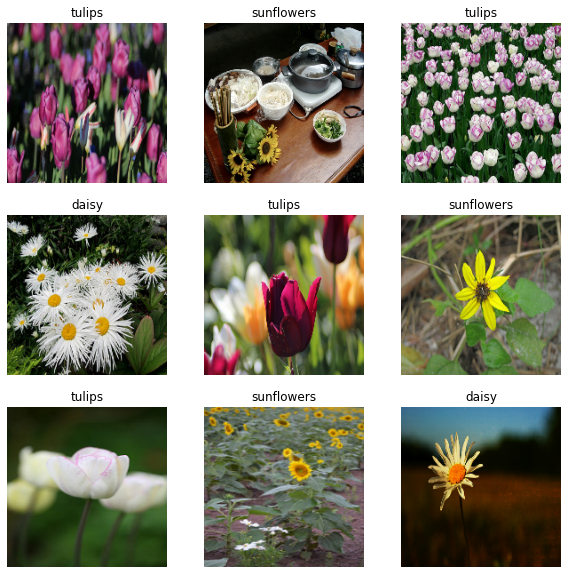

In [43]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [44]:
model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3
92/92 [==============================] - 3s 24ms/step - loss: 0.7462 - accuracy: 0.7302 - val_loss: 0.6849 - val_accuracy: 0.7384
Epoch 2/3
92/92 [==============================] - 2s 19ms/step - loss: 0.5614 - accuracy: 0.7967 - val_loss: 0.7325 - val_accuracy: 0.7262
Epoch 3/3
92/92 [==============================] - 2s 19ms/step - loss: 0.3935 - accuracy: 0.8610 - val_loss: 0.7357 - val_accuracy: 0.7616
